# Shoprite X Data Analysis

## Overview

### Business Context

- Two promotional campaigns are being tested (Group A and Group B)

- Targeted 5k customers in both groups and withheld 5k control groups for both groups.

- How did each of these groups perform against their control groups?

- Which promotional campaign was the more successful?

### "North Star" Metric

- Available metrics from the data are 'Sales Value', 'Transactions', and 'Quantity'

- These metrics are highly correlated to each other (refer to **Exploratory Data Analysis (EDA) > Correlations between Metrics**)

- The high correlation implies that analysis performed using any one of these metrics will yield similar inferences for the other metrics

- Given the retail business context, 'Sales Value' is chosen as the primary success metric for this investigation

## Import Packages

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from statsmodels.stats.power import TTestIndPower
import random

random.seed(10)  # initialise random seed for reproducability
sns.set(style="darkgrid")  

## Import Data and Create Datasets

In [18]:
data = pd.read_csv('./data/data.csv', sep=';')
redeemedvsnonredeemed = pd.read_csv('./data/redeemedvsnonredeemed.csv', sep=';')

ControlA = data[data.Group == 'ControlA']
ControlB = data[data.Group == 'ControlB']
TargetA = data[data.Group == 'TargetA']
TargetB = data[data.Group == 'TargetB']
TargetA['Sales Value'] = TargetA['Sales Value']

dataA = data[(data.DateLabel == 'Week 1 - 9') & ((data.Group == 'TargetA') | (data.Group == 'ControlA'))][['Date', 'Sales Value', 'Group']]
dfA = pd.DataFrame(dataA)

dataB = data[(data.DateLabel == 'Week 1 - 9') & ((data.Group == 'TargetB') | (data.Group == 'ControlB'))][['Date', 'Sales Value', 'Group']]
dfB = pd.DataFrame(dataB)

# Splitting the data into four groups: ControlA and TargetA, ControlB and TargetB
control_groupA = dfA[dfA['Group'] == 'ControlA']['Sales Value']
target_groupA = dfA[dfA['Group'] == 'TargetA']['Sales Value']
control_groupB = dfB[dfB['Group'] == 'ControlB']['Sales Value']
target_groupB = dfB[dfB['Group'] == 'TargetB']['Sales Value']

/var/folders/r7/j879zjdx3873kg8m59x1dnjm0000gp/T/ipykernel_90007/2660642807.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TargetA['Sales Value'] = TargetA['Sales Value']


## Exploratory Data Analysis (EDA)

### Correlations between Metrics

<Axes: >

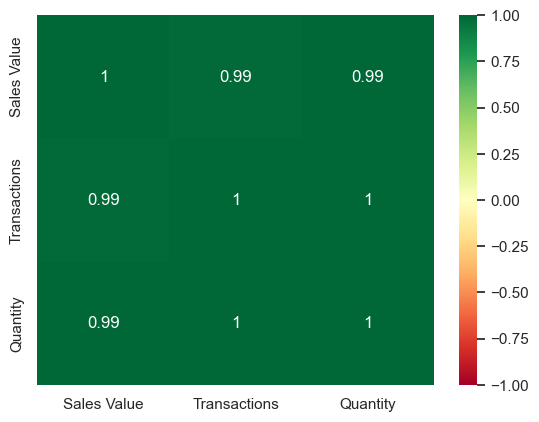

In [19]:
sns.heatmap(pd.DataFrame(data).corr(numeric_only=True), annot=True, cmap='RdYlGn', vmin=-1, vmax=1)

### Box plots

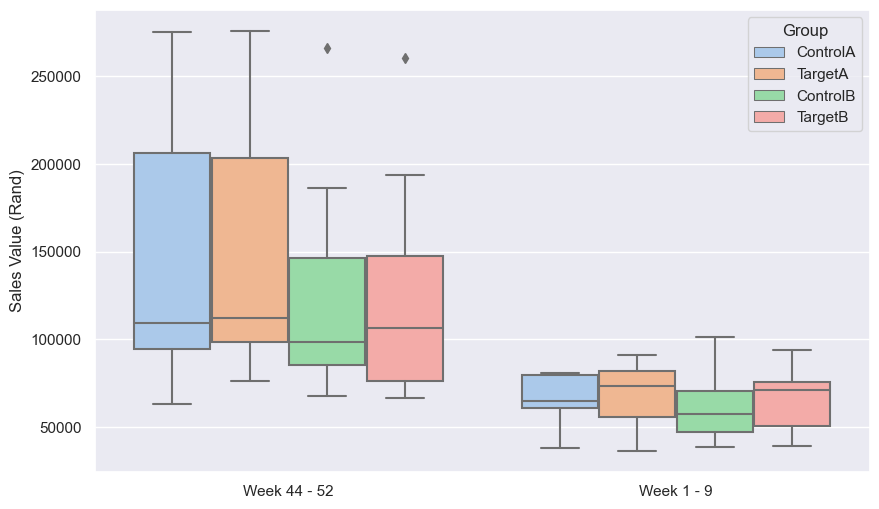

In [20]:
# Creating box plots using Seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(x='DateLabel', y='Sales Value', data=data, palette='pastel', hue='Group')

# Adding labels and title
plt.ylabel('Sales Value (Rand)')
plt.xlabel('')
plt.show()

## (Naive) Frequentist Approach...

$H_0 \rightarrow$ Null Hypothesis ("There is no statistically significant difference between the control and target groups")

$H_1 \rightarrow$ Alternative Hypothesis ("There **is** a statistical significant difference between the control and target groups")

### Hypothesis Testing: t-test

- Data has small sample size (i.e. 9 sample weeks) per group

- Population variance is unknown

- Therefore, t-test is the most appropriate statistical test to use in order to compare the sample means

- **Assumptions**: samples are independent and distribution is normal

In [21]:
alpha = 0.05  # Set your significance level

# Performing two-sample t-test
t_statA, p_valueA = ttest_ind(control_groupA, target_groupA, equal_var=False)
t_statB, p_valueB = ttest_ind(control_groupB, target_groupB, equal_var=False)

# Printing the results
print("Group A:")
print(f"T-statistic: {t_statA}")
print(f"P-value: {p_valueA}")

if p_valueA < alpha:
    print("Null hypothesis rejected. There is a significant difference between the groups.")
else:
    print("Failed to reject the null hypothesis. There is no significant difference between the groups.")

print()
print("Group B:")
print(f"T-statistic: {t_statB}")
print(f"P-value: {p_valueB}")

if p_valueB < alpha:
    print("Null hypothesis rejected. There is a significant difference between the groups.")
else:
    print("Failed to reject the null hypothesis. There is no significant difference between the groups.")

Group A:
T-statistic: -0.1756137392469407
P-value: 0.8629018056569583
Failed to reject the null hypothesis. There is no significant difference between the groups.

Group B:
T-statistic: -0.41784640558993225
P-value: 0.6816216839308394
Failed to reject the null hypothesis. There is no significant difference between the groups.


### Power Analysis

#### "What is the probability of detecting a significant effect (assuming one exists)"

power = $P$(reject $H_0 | H_1$ is true)

In [22]:
alpha = 0.05  # Alpha level

sample_sizeA = len(target_groupA)  
effect_sizeA = np.absolute(control_groupA.mean() - target_groupA.mean())/((target_groupA.std() + control_groupA.std())/2)
sample_sizeB = len(target_groupB) 
effect_sizeB = np.absolute(control_groupB.mean() - target_groupB.mean())/((target_groupB.std() + control_groupB.std())/2)

analysis = TTestIndPower()

# Calculate statistical power for a two-sample t-test
powerA = analysis.solve_power(effect_size=effect_sizeA, nobs1=sample_sizeA, alpha=alpha, alternative='two-sided')
powerB = analysis.solve_power(effect_size=effect_sizeB, nobs1=sample_sizeB, alpha=alpha, alternative='two-sided')

print('The statistical power for the given parameters is:')
print(f"Group A - {powerA:.4f}")
print(f"Group B - {powerB:.4f}")


The statistical power for the given parameters is:
Group A - 0.0532
Group B - 0.0679


#### "How many samples do we need to reliably detect an effect?"

In [23]:
alpha = 0.05  # Set the significance level
power = 0.8  # Set the desired statistical power

# Perform power analysis to determine sample size
analysis = TTestIndPower()
sample_sizeA = analysis.solve_power(effect_size=effect_sizeA, alpha=alpha, power=power, alternative='two-sided')
sample_sizeB = analysis.solve_power(effect_size=effect_sizeB, alpha=alpha, power=power, alternative='two-sided')

print(f"The required sample size for a two-sample t-test is:")
print(f"Group A - {sample_sizeA:.0f}")
print(f"Group B - {sample_sizeB:.0f}")

The required sample size for a two-sample t-test is:
Group A - 2265
Group B - 405


##### Sample size approximation: $n \approx \frac{16 \sigma_{pooled} ^2}{\Delta ^2}$

In [24]:

sample_size_approxA = 16*((target_groupA.std() + control_groupA.std())/2)**2/(control_groupA.mean() - target_groupA.mean())**2
sample_size_approxB = 16*((target_groupB.std() + control_groupB.std())/2)**2/(control_groupB.mean() - target_groupB.mean())**2
print('The (approximate) required sample size for a two-sample t-test is:')
print(f"Group A - {sample_size_approxA:.0f}")
print(f"Group B - {sample_size_approxB:.0f}")

The (approximate) required sample size for a two-sample t-test is:
Group A - 2307
Group B - 412


## Bayesian Approach...

### Approximating the Posterior Distribution using Central Limit Theorem

**Assumtions**: The sample data is independent and identically distributed (i.i.d.)

In [25]:
def central_limit_theorem(population_sample, sample_size):
    sample_means = []
    Sample_Size = 100000
    for _ in range(Sample_Size):  # Number of iterations for sample means
        sample = np.random.choice(population_sample, sample_size, replace=True)
        sample_mean = np.mean(sample)
        sample_means.append(sample_mean)    
    return sample_means 

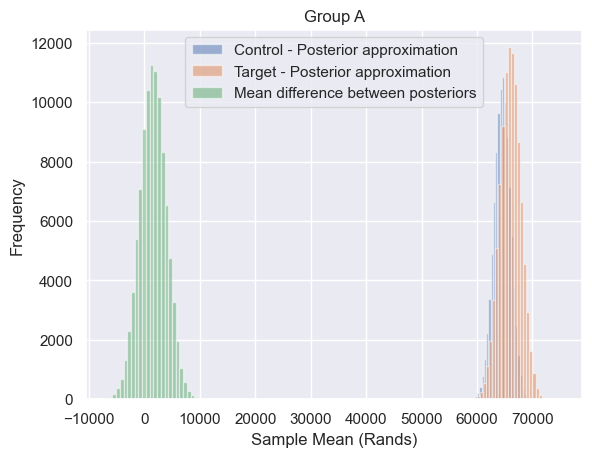

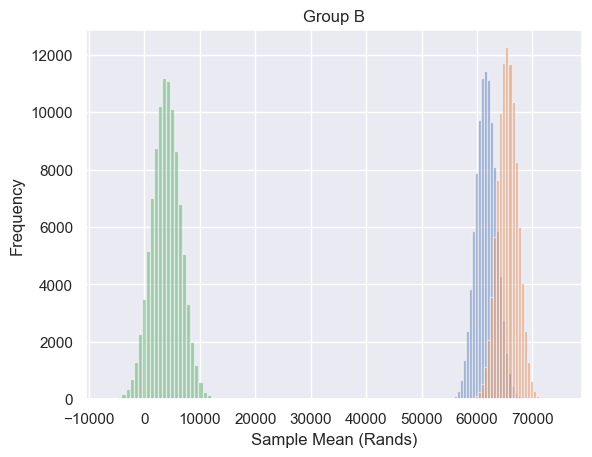

In [26]:
sample_means_controlA = central_limit_theorem(control_groupA, 100)
sample_means_targetA = central_limit_theorem(target_groupA, 100)
mean_differenceA = np.array(sample_means_targetA) - np.array(sample_means_controlA)

sample_means_controlB = central_limit_theorem(control_groupB, 100)
sample_means_targetB = central_limit_theorem(target_groupB, 100)
mean_differenceB = np.array(sample_means_targetB) - np.array(sample_means_controlB)

plt.figure()
plt.hist(sample_means_controlA, bins=30, alpha=0.5, label='Control - Posterior approximation')
plt.hist(sample_means_targetA, bins=30, alpha=0.5, label='Target - Posterior approximation')
plt.hist(mean_differenceA, bins=30, alpha=0.5, label='Mean difference between posteriors')
plt.title('Group A')
plt.xlabel('Sample Mean (Rands)')
plt.ylabel('Frequency')
plt.xlim(-10500, 79000)
plt.legend()

plt.figure()
plt.hist(sample_means_controlB, bins=30, alpha=0.5, label='Control')
plt.hist(sample_means_targetB, bins=30, alpha=0.5, label='Target')
plt.hist(mean_differenceB, bins=30, alpha=0.5, label='Mean Difference')
plt.title('Group B')
plt.xlabel('Sample Mean (Rands)')
plt.ylabel('Frequency')
plt.xlim(-10500, 79000)
plt.show()

### Effect and Uncertainty

In [27]:
print("The average effect and associated uncertainty is:")
print(f"Group A - {np.mean(mean_differenceA):.4f} +/- {np.std(mean_differenceA):.4f}")
print(f"Group B - {np.mean(mean_differenceB):.4f} +/- {np.std(mean_differenceB):.4f}")

The average effect and associated uncertainty is:
Group A - 1495.5068 +/- 2384.9549
Group B - 3840.0605 +/- 2605.4044


### "What is the probability that the promotion had a positive effect?"

In [28]:
print("The probability that the promotion had a positive effect is:")
print("Group A - ", np.mean(mean_differenceA > 0))
print("Group B - ", np.mean(mean_differenceB > 0))

The probability that the promotion had a positive effect is:
Group A -  0.73513
Group B -  0.929


### "What is the probability that the promotion resulted in an average loss of R5,000 (or more)?"

In [29]:
print("The probability that the promotion resulted in an average loss of R5,000 (or more) is:")
print("Group A - ", np.mean(mean_differenceA <= -5_000))
print("Group B - ", np.mean(mean_differenceB <= -5_000))

The probability that the promotion resulted in an average loss of R5,000 (or more) is:
Group A -  0.00332
Group B -  0.0005


## Further Analysis: Redeemed vs Not Redeemed

### Promotion Redemption Table

In [30]:
redeemedvsnonredeemed

,Group,Redeemed vs Non-Redeemed,Sales Amount,Transactions,Sales Quantity,Customers
0,TargetA,Not Redeemed,503407.53,1905,2308,1260
1,TargetA,Redeemed,90668.54,304,369,171
2,TargetB,Not Redeemed,455860.56,2025,2474,1291
3,TargetB,Redeemed,133346.80,496,544,278


### Notable percentages

In [31]:
print('Percentage of target customers who redeemed (Weeks 1 - 9):')
print(f'Group A - {redeemedvsnonredeemed.Customers[1]/(redeemedvsnonredeemed.Customers[0] + redeemedvsnonredeemed.Customers[1]):.4f}')
print(f'Group B - {redeemedvsnonredeemed.Customers[3]/(redeemedvsnonredeemed.Customers[2] + redeemedvsnonredeemed.Customers[3]):.4f}')

Percentage of target customers who redeemed (Weeks 1 - 9):
Group A - 0.1195
Group B - 0.1772


In [32]:
print('Percentage of target customers who redeemed (Weeks 44 - 52 and Weeks 1 - 9):')
print(f'Group A - {redeemedvsnonredeemed.Customers[1]/(4993):.4f}')
print(f'Group B - {redeemedvsnonredeemed.Customers[3]/(4989):.4f}')

Percentage of target customers who redeemed (Weeks 44 - 52 and Weeks 1 - 9):
Group A - 0.0342
Group B - 0.0557


### Possible Reasons Why Customer Engagement is Low

- Insufficient awareness of promotion among target customers

- Difficulties with redeeming promotion (e.g. required loyalty cards to redeem promotion)

- Specific deal / category was not relevent to most of the target customers

## Summary

- Insufficient data to reliably use frequentist approach (refer to power analysis)

- Bayesian approach showed that the promotion campaign likely had a positive effect on sales for both Group A and B

- Promotion campaign for Group B was statistically more successful compared to promotion campaign for Group A

- Low ratio of customers that participated in the promotion for both Group A and B

## Recommendations for Future Promotion Campaigns

- Continue with Group B promotion campaign and abandon the group A promotion campaign

- Improve marketing techniques for target group, ensuring that they are aware of the promotion

- Improve the promotion offering to attract more customers and increase customer engagement from the target group

- Run promotion campaign over longer period to generate more data for future analyses

- Generate data on a daily basis (rather than weekly), as this will allow for a more granular analysis